# Deep Probabilistic Models

# Tutorial 2: An Introduction to Pyro and Variational Inference

In this tutorial, you will cover some Pyro basics and see two types of model implemented. 


Recall, that the general framework for training models via Variational Inference is to solve the problem

$$\arg \max_{\boldsymbol{\phi}, \boldsymbol{\theta}}\mathbb{E}_{q_{\boldsymbol{\phi}}}\big[\log p_{\boldsymbol{\theta}}(\mathbf{x},\mathbf{z}) - \log q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \big]$$

via (stochastic) gradient methods.



In Pyro: 

* The `model` function specifies your model, whereas the `guide` function specifies you posterior approximation.
* `sample` denotes a random variable in the model (i.e., an element of $\mathbf{z}$ or $\mathbf{x}$)
   
* `param` denotes something you wish to optimize over (i.e., an element of $\phi$ or $\theta$). 
    * All `param` in the model function are elements of $\theta$
    * All `param` in the guide function are elements of $\phi$

* Inputs to the model function denote deterministic things that will **not** be optimized.

* `pyro.plate` is used to denote conditional independence

In [1]:
import pyro 
import torch as t 
import matplotlib.pyplot as plt 
t.manual_seed(123)

First, we shall generate some binary-valued data...

In [2]:
distX = t.distributions.Bernoulli(0.65)
x_obs = distX.sample([100])
print(x_obs)

tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 1.])


### Beta-Bernoulli Model

We begin with a classic model, a Bernoulli likelihood with a Beta prior. The generative form of the model is

$$ p \sim {\rm Beta}(1,1)$$

$$X_k | p \sim_{\rm iid} {\rm Bernoulli}(p),\quad k=1,\ldots,N.$$



<img src="BerPlate.png" width="400">

Thus, the variable $p$ which is the parameter of the Bernoulli variable is **latent**. However, we have **observed** $X_1, \ldots, X_N$ and wish to perform **posterior inference** on $p$, i.e., infer the distribution of $p | X_1, \ldots, X_N$. 


The model is implemented in Pyro below. Note that we specify `obs` for `x`, which are the observations. This tells Pyro that ${\bf X}$ is an observed variable in our directed graphical model.  Note also that we use `pyro.plate` as a **context**. To learn more about *context managers* in Python, have a read [here](https://www.pythontutorial.net/advanced-python/python-context-managers/).  



In [3]:
import pyro.distributions as dist
import torch  
from torch.distributions import constraints

def BetaBernoulli():  
    # "sample" statements put variables in the graphical model
    p = pyro.sample('p', dist.Beta(1,1)) 
    
    with pyro.plate("data", x_obs.shape[0]):
        x = pyro.sample('x', dist.Bernoulli(probs = p), obs = x_obs)
    
    return x

### Bayesian Inference with VI 

Next, we will perform "fully Bayesian" inference over the parameter (as opposed to maximizing the likelihood). To do so, we need to specify the variational family $q_{\phi}$. In Pyro, anything that provides an approximate posterior is called a `guide` (variational approximations are one example of this, and the main use). One can specify a variational distribution for any `model` in Pyro but creating a `guide` model that gives the generative form of the variational approximation (thus, you can have all types of interesting structure in your approximation if you desire). 

As $p \in (0,1)$, we will use the Beta distribution family as our approximation (actually it is a very good one, as it is possible to derive by hand in this case that the posterior over $p$ is actually a Beta distribution! 

Note that below, we tell Pyro our **variational parameters** (elements of $\phi$) and the constraints we wish them to have. In the Beta distribution's parametrization, both parameters **must** be positive. This is easy to specify, note below we tell Pyro this. 

What actually happens in the background is Pyro optimizes over unconstrained space and then transforms the variational parameters to constrained space. For example, it may optimize the over $\log(a)$ and $\log(b)$ so there are no constraints, and then transform them at the end. 

In [4]:
def guide():
    a = pyro.param("a", torch.tensor(1.),  constraint=constraints.positive)
    b = pyro.param("b", torch.tensor(1.),  constraint=constraints.positive)
    
    p = pyro.sample('p', dist.Beta(a,b))
    return p 

Text(0.5, 0, 'Iteration')

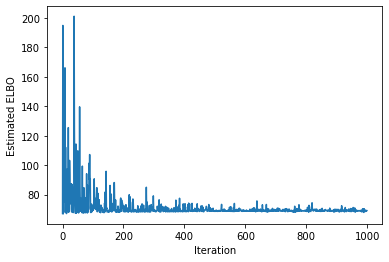

In [5]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=BetaBernoulli,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 0.1}),
                     loss=pyro.infer.Trace_ELBO())

ELBO = [] 
num_steps = 1000
for t in range(num_steps):
     ELBO.append(svi.step())
        
plt.plot(ELBO)
plt.ylabel("Estimated ELBO")
plt.xlabel("Iteration")

The following code plots our approximate posterior by simulating from the variational approximation and fitting a kernel density function (we could have also done this by plotting the beta pdf, but more generally you do not know the marginals, so in many cases one needs to do this). 

<AxesSubplot:ylabel='Density'>

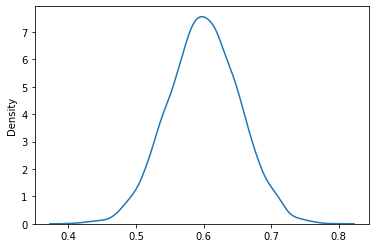

In [6]:
import torch as t
from seaborn import kdeplot as kde 

vals = t.tensor([guide().item() for k in range(5000)]).numpy()
kde(x = vals)

Pyro actually has an MCMC engine as well! It has the same state-of-the-art implementation of the Hamiltonian Monte Carlo No-U-Turn sampler as **Stan**. Run the code below to approximate the posterior distribution with MCMC.  

In [7]:
mySampler = pyro.infer.MCMC(
        kernel = pyro.infer.NUTS(model=BetaBernoulli, jit_compile=True),
        num_samples=5000,
        warmup_steps=500,
        num_chains=1)

mySampler.run()

Warmup:   0%|          | 0/5500 [00:00, ?it/s]/Users/rob/opt/anaconda3/lib/python3.7/site-packages/pyro/poutine/subsample_messenger.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 5500/5500 [00:16, 338.27it/s, step size=8.80e-01, acc. prob=0.946]


After running MCMC, we can call `.summary()` on the sampler to obtain information about the parameters. We also see the effective sample size, as well as the Gelman-Rubin diagnostic `r_hat`. 

In [8]:
mySampler.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.61      0.05      0.61      0.53      0.68   2228.89      1.00

Number of divergences: 0


<AxesSubplot:ylabel='Density'>

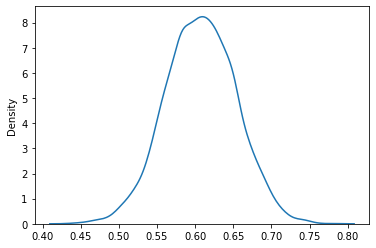

In [9]:
x = mySampler.get_samples()['p'].numpy()
kde(x)

Note that both MCMC and VI give roughly the same answer! That is neat, but remember (1) this is a simple 1D example, and (2) we know that our variational family (guide) contains the true posterior.

#### Autoguide

Generally, we may have a complicated model that we don't want to spend the effort crafting a guide for piece by piece. Fortunately, `Pyro` provides off-the-shelf variational approximations in the `autoguide` module. 

Below we tell `Pyro` we want a variational approximation of our model `BetaBernoulli` that is a multivariate normal with diagonal covariance matrix (i.e., independent normals). However, because this is a one-dimensional example, this is the same as saying we want to just have a 1D ${\cal N}(\mu, \sigma^2)$ approximation.  

You may recall however that the variable $p$ needs lie in the interval $(0,1)$, and clearly a normal distribution goes outside that interval. The good news is, `Autoguide` automatically reparametrizes (transforms) everything behind the scenes, so it fits a normal distribution in unconstrained space, and then transforms it to $(0,1)$. 

In [10]:
from pyro.infer.autoguide import AutoDiagonalNormal

myAutoGuide = AutoDiagonalNormal(BetaBernoulli)

Text(0.5, 0, 'Iteration')

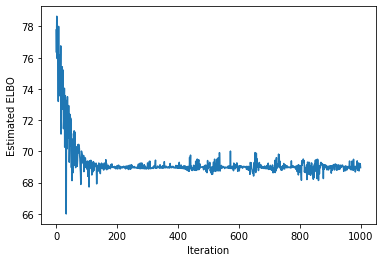

In [11]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=BetaBernoulli,
                     guide=myAutoGuide,
                     optim=pyro.optim.Adam({"lr": 0.01}),
                     loss=pyro.infer.Trace_ELBO())

ELBO = [] 
num_steps = 1000
for t in range(num_steps):
     ELBO.append(svi.step())
        
plt.plot(ELBO)
plt.ylabel("Estimated ELBO")
plt.xlabel("Iteration")

<AxesSubplot:ylabel='Density'>

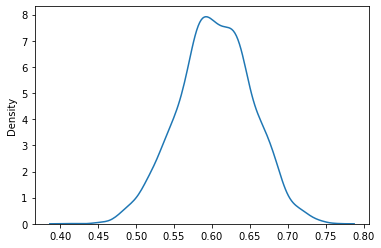

In [12]:
import torch as t
from seaborn import kdeplot as kde 

vals = t.tensor([myAutoGuide()["p"].item() for k in range(5000)]).numpy()
kde(x = vals)

### Other AutoGuides

### 2. Bayesian Linear Regression featuring Shrinkage Priors

In the next example, we will do Bayesian Linear Regression with two different priors. 

In [13]:
import numpy as np
import torch as t
import torch 


#-------- we will change this in the exercise ---
d=100 # number of parameters
n_samples = 100 # number of samples
#-----------------------------------------------

beta = t.zeros(d)

for i in range(d):
    if i < d/2:
        if np.random.rand()<.5:
            beta[i] = 5 + torch.randn(1).reshape(-1,1)
        else: 
            beta[i] = -5 + torch.randn(1).reshape(-1,1)
    else: 
        beta[i] = 0


X = t.randn([n_samples,d])
y_obs = X @ beta.reshape(-1,1) +  0.5 * t.randn(n_samples,1)

y_obs.shape



torch.Size([100, 1])

The following code defines the Bayesian Linear Regression model.

$$\beta \sim_{\rm iid} {\cal N}(0, 10^2) $$

$$\sigma^2 \sim {\rm InverseGamma}(0.1,0.1)$$

$$y_i | \beta, \sigma^2 \sim {\cal N}(\beta^\top {\bf x}_k, \sigma^2)$$

In [14]:
import pyro
from pyro.distributions import Normal
from pyro import sample
import pyro.distributions as dist

def LR():   
    # ---- p(theta) -----------------------
    beta = sample('beta', Normal(loc=0. , scale=10.).expand([d]).to_event(1) )
    sigma_sq = sample('sigma_sq', dist.InverseGamma(.1,.1))
 
    # ---- p(y|theta) ---------------------
    with pyro.plate("data", X.shape[0]):
        y = pyro.sample('y', Normal(X @ beta.reshape(-1,1), t.sqrt(sigma_sq)).to_event(1), obs = y_obs)
    
    return y

As the model is more sophisticated and we do not wish to go to the effort of crafting a guide, we can use an "off the shelf" `AutoGuide` that fits a multivariate normal. 

0 1093.88
250 993.49
500 957.6
750 879.38
1000 834.18
1250 803.74
1500 789.23
1750 767.76
2000 731.52
2250 692.86
2500 669.57
2750 657.27
3000 631.49
3250 607.38
3500 602.58
3750 590.15
4000 593.4
4250 571.58
4500 576.04
4750 577.53
5000 577.43
5250 565.42
5500 565.96
5750 566.99
6000 558.22
6250 573.35
6500 556.48
6750 564.27
7000 553.37
7250 559.26
7500 560.0
7750 564.82
8000 547.85
8250 561.31
8500 551.63
8750 555.76
9000 551.26
9250 554.2
9500 546.67
9750 548.38


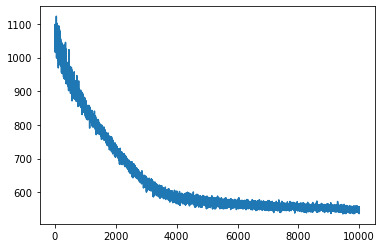

In [15]:
guide = pyro.infer.autoguide.AutoMultivariateNormal(LR)

pyro.clear_param_store()
svi = pyro.infer.SVI(model=LR,
                     guide=guide,
                     optim=pyro.optim.Adam({"lr": 1e-3}),
                     loss=pyro.infer.Trace_ELBO())

ELBO = [] 
num_steps = 10000
for s in range(num_steps):
     ELBO.append(svi.step())
     if s % 250 == 0: print(s, round(ELBO[-1],2))  
        
plt.plot(ELBO)        

The code below will plot the median (red) and 95% credible intervals (blue) of the approximate posterior (i.e., the variational approximation). The true parameters that generated the data will be plotted as black stars. 

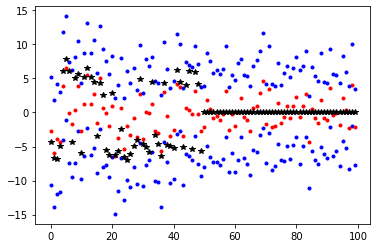

In [16]:
l = guide.quantiles([0.025])['beta'][0].numpy()
m = guide.quantiles([0.5])['beta'][0].numpy()
u = guide.quantiles([0.975])['beta'][0].numpy()

plt.plot(l, 'b.', m, 'r.', u, 'b.')
plt.plot(beta.numpy(), 'k*')

Not too bad! However, you will have noticed that the parameter estimates are all over the place. This is unsurprising as we have a lot of parameters relative to data.  

### Horseshoe Prior

In settings where there are a lot of parameters and not much data, it is advantageous to use 

The **Horseshoe Prior** is a prior that encourages this behaviour. It is specially designed to shrink the posterior of any parameters that are small toward zero, while simultaneously allowing larger parameters to be unaffected. See [this paper](http://proceedings.mlr.press/v5/carvalho09a/carvalho09a.pdf) if you are interested to learn more about this magical prior.

The model in generative form is: 

$$\tau \sim {\rm HalfCauchy}(1)$$ 
$$\lambda_i \sim_{\rm iid} {\rm HalfCauchy}(1), \quad i = 1,\ldots, d.$$ 

$$\beta_j | \tau, \lambda_k \sim_{\rm ind} {\cal N}(0, \tau^2 \lambda_k^2), \quad j=1,\ldots,d. $$

$$y_k \sim_{\rm ind} {\cal N}(\beta^{\top}\mathbf{x_k}, \sigma^2)   , \quad k=1,\ldots, N.$$


Note that more generally we can pick some other prior for $\tau$. 

It is important to note that the above model does not put a prior on $\sigma^2$. We could if we wanted to, but instead we will simply optimize over $\sigma^2$ in the **empirical Bayes** fashion. Note that in the code below, we tell `Pyro` that we wish to do this by specifying `sigma` as a `param` and not by giving it a `sample` statement (which would require us to specify a prior for it).  


#### Exercise (optional, but fun!): Write the above model as a directed graphical model using Plate Notation. Be sure to include all conditional independences!

N.B. *For simplicity, I have not included an intercept term in the model. However, it is easy to add one by adding a column of ones to the matrix $x_{\rm obs}$ and changing $d$ to $d+1$, but we won't worry about doing that in this tutorial.*


In [17]:
def HorseshoeLR():   
    # ---- p(theta) -----------------------
    tau = pyro.sample('tau', dist.HalfCauchy(scale=1.))
    lam = pyro.sample('lambda', dist.HalfCauchy(scale=1.).expand([d]).to_event(1))
    
    beta = sample('beta', Normal(loc=0. , scale=tau*lam).to_event(1) )
    sigma = pyro.param("sigma", torch.tensor(1.),  constraint=dist.constraints.positive)
 
    # ---- p(y|theta) ---------------------
    with pyro.plate("data", X.shape[0]):
        y = pyro.sample('y', Normal(X @ beta.reshape(-1,1), sigma**2).to_event(1), obs = y_obs)
    
    return y

Above, you will notice the code uses two new commands: `expand`, and `to_event`. The former just tells `Pyro` to replicate the vector, the latter tells `Pyro` to treat the elements as one object (we need to do this for `autoguide` to work for technical reasons). 

As we are being empirically Bayesian about $\sigma^2$, and also because even if we weren't the Horseshoe prior makes a posterior that is highly problematic for HMC (due to funnel-like behaviours), we are going to use Variational Learning to fit out model. 

In a little bit, you will get to experiment by changing the dimension of the data. We will assume all of our latents (in this case, parameters we are being Bayesian about) can be fit with a variational approximation that is of the form ${\cal N}(\mu, {\rm diag}({\bf v}) + {\bf b}{\bf b}^\top)$, where ${\bf b}$ is a $d$-dimensional vector. For further discussion of variational distributions of this form, see the paper by [Ong et al. (2017)](https://www.tandfonline.com/doi/full/10.1080/10618600.2017.1390472).
  



In [18]:
from pyro.infer.autoguide import AutoLowRankMultivariateNormal

guideHS = AutoLowRankMultivariateNormal(HorseshoeLR, rank=1)

svi = pyro.infer.SVI(model=HorseshoeLR,
                     guide=guideHS,
                     optim=pyro.optim.Adam({"lr": 1e-3}),
                     loss=pyro.infer.Trace_ELBO())

ELBO = [] 
num_steps = 50000
for t in range(num_steps):
     pyro.clear_param_store()
     ELBO.append(svi.step())
     if t % 500 == 0: print(t, round(ELBO[-1],2))

0 64696.04
500 48265.17
1000 35578.67
1500 26589.38
2000 20258.09
2500 14966.48
3000 11438.76
3500 8465.06
4000 6419.49
4500 4769.9
5000 3746.57
5500 2772.56
6000 2154.49
6500 1635.91
7000 1387.35
7500 1096.66
8000 933.66
8500 843.93
9000 743.8
9500 703.48
10000 669.68
10500 638.98
11000 629.73
11500 583.33
12000 582.39
12500 567.68
13000 547.43
13500 553.09
14000 552.72
14500 544.32
15000 543.05
15500 539.5
16000 542.58
16500 549.21
17000 546.58
17500 543.67
18000 540.14
18500 538.88
19000 537.23
19500 539.87
20000 544.17
20500 547.56
21000 533.36
21500 523.82
22000 538.04
22500 529.34
23000 520.57
23500 520.23
24000 538.91
24500 543.89
25000 555.77
25500 520.85
26000 533.06
26500 522.7
27000 524.22
27500 524.07
28000 536.98
28500 537.35
29000 542.93
29500 535.71
30000 519.38
30500 511.44
31000 528.51
31500 533.06
32000 527.27
32500 519.54
33000 510.67
33500 534.4
34000 523.23
34500 530.02
35000 528.54
35500 520.79
36000 538.32
36500 520.44
37000 508.06
37500 529.91
38000 517.66
38500

Text(0, 0.5, 'Estimated ELBO')

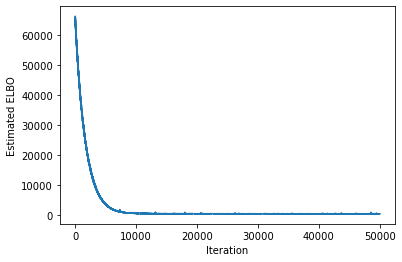

In [19]:
plt.plot(ELBO)
plt.xlabel("Iteration")
plt.ylabel("Estimated ELBO")

Text(0.5, 1.0, 'Horseshoe Prior w/VI')

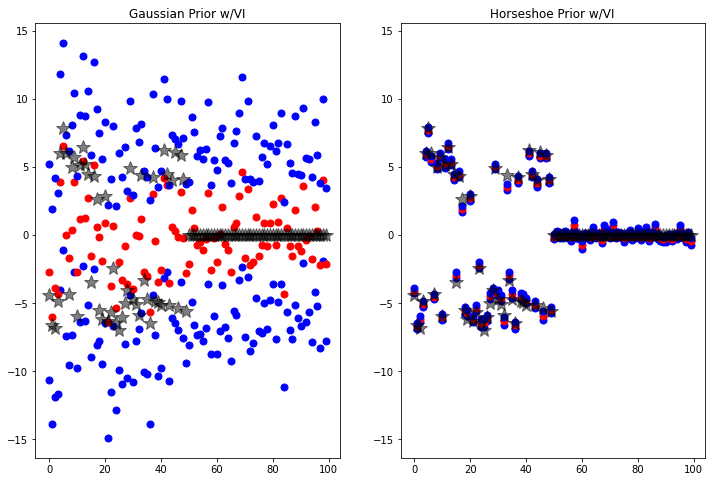

In [36]:
plt.rcParams['figure.figsize'] = [12, 8]
ax1 = plt.subplot(121)

l = guide.quantiles([0.025])['beta'][0].numpy()
m = guide.quantiles([0.5])['beta'][0].numpy()
u = guide.quantiles([0.975])['beta'][0].numpy()

plt.plot(l, 'b.', m, 'r.', u, 'b.', markersize=14)

plt.plot(beta.numpy(), 'k*', alpha=0.5, markersize=14)
plt.title("Gaussian Prior w/VI")
ax2 = plt.subplot(122, sharey = ax1)

lHS = guideHS.quantiles([0.025])['beta'][0].numpy()
mHS = guideHS.quantiles([0.5])['beta'][0].numpy()
uHS = guideHS.quantiles([0.975])['beta'][0].numpy()

plt.plot(lHS, 'b.', mHS, 'r.', uHS, 'b.', markersize=14)
plt.plot(beta.numpy(), 'k*', alpha = 0.5, markersize=14)
plt.title("Horseshoe Prior w/VI")



### An Aside: 
It is worth noting that Pyro has other variational objective functions besides ELBO: For example [Tail-adaptive f-Divergence](https://arxiv.org/pdf/1810.11943.pdf) and the Importance Weighted Variational objective. (I believe doubly reparametrized "Sticking the Landing" gradients for the latter are a feature thats coming soon). 


### Exercise
Investigate the effectiveness of Gaussian Prior vs Horseshoe Prior for different dimensions of data `d` and different number of samples `n_samples`. As Variational Inference/Learning is quite quick, you should be able to do it in high dimensions and with bigger datasets. 

### 3. A (very) Brief Introduction to `torch.nn.Module` and its use in `Pyro`

In `PyTorch`, a very important aspect are `module` objects. A key aspect of `Pyro` is that one can use modules everywhere. This allows for **very flexible** models, and approaches such as amortized inference (using a neural network to determine the variational parameters given the data).

However, it suffices to note that a `module` can be anything as simple as an activation function (e.g., `nn.Sigmoid`) , a layer of a neural network (eg., `nn.Linear`, `nn.Conv2D`), or even the composition of other `module` objects (e.g., a whole neural network can be a single `module` object).


For those interested in how they are used within `Pyro`, see the online tutorial [Modules in Pyro](http://pyro.ai/examples/modules.html). Though note that this does require a more advanced knowledge of how to create and use `module` objects. 

Using `module` objects within ones model (e.g., Deep Bernoulli model) or one's variational approximation (e.g., neural nets used in Amortized Inference) is the core of **deep probabalistic programming**.  `Pyro` can also have `module` objects that are fully Bayesian, i.e., have priors on all of their parameters. Another example of how one may use `modules` in the `guide` is through flexible conditionally structured approximations. For example, our posterior approximating variational family may take the form:

$${\bf Z}_1 \sim {\cal N}({\bf \mu_1}, \Sigma_1)$$
$${\bf Z}_2 | {\bf Z}_1 \sim {\cal N}(g_{\xi}({\bf Z_1}), \Sigma_2),$$

where ${\bf g}_{\xi}: \mathbb{R}^{{\rm dim}({\bf Z}_1)} \rightarrow \mathbb{R}^{{\rm dim}({\bf Z}_2)} $ is a neural network, say. Of course, designing such approximations that optimize well and capture the posterior characteristics of interest is the topic of ongoing research, but `Pyro` in principle can easily implement such things.

These **incredible features** are beyond the scope of this tutorial, however, in this section we provide a brief overview of how `module` objects work in base PyTorch. This is also useful to know if you 

Below is a **very basic** walkthrough of creating a module object and how it can be used. 

In [37]:
import torch 
import torch.nn as nn 

Below we create a new `module` type called `Linear` that mimics how `torch.nn.Linear` module works under the hood. 

In [38]:
class Linear(nn.Module):
    def __init__(self, dim_in, dim_out):
        # runs constructor for the class we are inheriting from 
        super().__init__() 
        # initialize the weight and bias parameters
        self.W = nn.Parameter(torch.randn(dim_out, dim_in))
        self.b = nn.Parameter(torch.zeros(dim_out))

    def forward(self, X):
        return X @ self.W.T + self.b

Below, I create a new object `LR` of type `Linear`.

In [39]:
LR = Linear(dim_in=5, dim_out = 1)

In [40]:
V = torch.randn(3,5)

The `forward` method of a `nn.Module` object is its *default* method. That is, if you call the module as it it  is a function

In [41]:
# these two commands do the same thing 
LR(V)

tensor([[ 1.4408],
        [ 1.8738],
        [-1.6663]], grad_fn=<AddBackward0>)

Calling `parameters()` will not actually show them, because it is a `generator` object. This just means it is something that can output things when iterated through. 

In [42]:
LR.forward(V)

tensor([[ 1.4408],
        [ 1.8738],
        [-1.6663]], grad_fn=<AddBackward0>)

In [43]:
LR.parameters()

<generator object Module.parameters at 0x7ffdfd3856d0>

We can view all the parameters in a module by iterating through its `parameters()` generator

In [44]:
for p in LR.parameters():  print(p)

Parameter containing:
tensor([[ 0.0106,  0.3921, -0.0757, -0.9743, -1.8849]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


We can do the above and also show the names by iterating with the `named_parameters()` generator. Having all parameters contained in a module object makes it easy to pass things to an`optimizer` object (e.g., `torch.optim.adam`. We just need to give it the `parameters` generator upon initialization. It is also easy to tell `Pyro` that all parameters in a module should be part of $\theta$ in a model or $\phi$ in the variational approximation that need to be optimized over. 

Note that by default all parameters in the layer have `requires_grad` set  to true, so PyTorch watches operations made on them for backpropagation. 

In [45]:
for p in LR.named_parameters(): print(p)

('W', Parameter containing:
tensor([[ 0.0106,  0.3921, -0.0757, -0.9743, -1.8849]], requires_grad=True))
('b', Parameter containing:
tensor([0.], requires_grad=True))


The purpose of the above was to demonstrate constructing a custom module. As a linear operation is very simple, we could have just done it with `PyTorch`'s built in module. 

In [46]:
L = torch.nn.modules.Linear(5,1)

In [47]:
for p in L.named_parameters(): print(p)

('weight', Parameter containing:
tensor([[ 0.2531, -0.1226,  0.0393,  0.3131, -0.0659]], requires_grad=True))
('bias', Parameter containing:
tensor([-0.2141], requires_grad=True))


Note that `nn.modules.Sigmoid` is a `nn.Module`, as are most activation funcions.

#### Vectorization
While it is very natural to think of a linear module applying the transformation 
${\bf y} = \mathrm{A}{\bf x} + {\bf b},$
above, we (and in its own linear model `PyTorch`) do not actually do it that way. The reason why is that we want to **vectorize**, that is, to do computations for several vectors of $\mathbf{x}$ in one go. 

Tricks like this are very important for speeding up `PyTorch`'s performance when using GPUs (as GPUs can do tensor operations very fast, but other things not so much). 


In [48]:
import torch as t

A = t.tensor([[1,2], [3,4]])
X = t.tensor([[1,1], [3,2]])

In [49]:
# the tedious way 

h = t.zeros(2,2)

for i in [0,1]: 
    h[i,:] = A @ X[i,:]

print(h)

tensor([[ 3.,  7.],
        [ 7., 17.]])


In [50]:
X @ A.T # the smart way to do the same thing

tensor([[ 3,  7],
        [ 7, 17]])

It should hopefully not surprise you that  using 



In [51]:
A @ X

tensor([[ 7,  5],
        [15, 11]])

does not yield the same answer, as the latter computes a product of two matrices (treats x as a matrix and not as two rows). 

The advantage of this **vectorization** is that we can compute everything with **one** tensor operation and no for loops, GPUs are very good at such operations!

# 4. Pyro Tutorials on Variational Autoencoders

Where `Pyro` really shines is implementing sophisticated models with techniques such as **amortized inference**. This is quite advanced. However, above tutorial should make you well equipped to begin to understand some of the more advanced `Pyro` examples. Have a read through the following two examples, and see how much you can now follow! 

N.B. In the `Pyro` tutorials below, the plate diagram for the VAE has a circle around the parameter vector $\theta$. If one follows the convention that variables that are random (have a prior) are circled in the plate diagram, then the diagram they have is incorrect. The implemented VAE is not "fully Bayesian" with respect to $\theta$, but simply maximizes the ELBO over the parameter values (recall we discussed why this may be a better choice in the lecture).

[Variational Autoencoders Tutorial](https://pyro.ai/examples/vae.html) 

[Conditional Variational Autoencoders Tutorial](https://pyro.ai/examples/cvae.html)